In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
folder_path = "Data/SimulationData"

# List of .txt file in the directory
file_list = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path)
                     if file.endswith('.txt')],
                    key=lambda x: int(re.search(r'job_(\d+)\.txt', x).group(1)))

# DataFrame for all the data
merged_df = pd.DataFrame()

# Arranging the files in groups of 24 (each group represents a single fiber)
file_groups_by_fiber = [file_list[i:i+24] for i in range(0, len(file_list), 24)]

for group_num, files_in_group in enumerate(file_groups_by_fiber, start=1):

    #print(f"Group {group_num} elaboration")
    group_df = pd.DataFrame()

    for file in files_in_group:
        try:
            # Try reading the file and adding it to the group DataFrame
            df = pd.read_csv(file,sep="\t")

            # Computing photons' distance from the center and filtering the non-physical ones
            df['center_dist'] = np.sqrt(df['# y_exit']**2+df['z_exit']**2)
            df = df[df['center_dist']<=0.125]

            # Computing the theta angle w.r.t. the fiber's axis
            df['Theta_rad'] = np.arccos(df['px_start'])
            df['Theta_deg'] = df['Theta_rad']*57.2958

            #Computing the r_min
            df['r_min'] = np.abs((df['pz_start'] * df['y_start'] - 
                                        df['py_start'] * df['z_start'])
                                       /(np.sqrt(df['pz_start']**2 + df['py_start']**2)))

            # Filtering DataFrame excluding Rayleigh scattering
            df = df[df['rayleighScatterings'] == 0]
            df = df.drop('rayleighScatterings',axis=1)

            group_df = pd.concat([group_df, df], ignore_index=True)

        # Skipping parsing and decoding errors
        except pd.errors.ParserError:
            #print(f"File {file} in group {group_num} couldn't be read correctly. Going to the next.")
            continue

        except UnicodeDecodeError:
            #print(f"Error in Unicode decoding in file {file} in group {group_num}. Going to the next.")
            continue
    
    # Adding a column to the DataFrame to indicate the corresponding fiber
    group_df['Fiber'] = group_num
    
    # Merging the group and the main DataFrames
    merged_df = pd.concat([merged_df, group_df], ignore_index=True)

merged_df.head


<bound method NDFrame.head of          # y_exit    z_exit      x_start   y_start   z_start  px_start  \
0       -0.026978 -0.061619  2400.019897 -0.051878  0.096635  0.948434   
1       -0.055254  0.050902  2400.000732  0.085666  0.015889  0.977825   
2        0.049212  0.065583  2399.990967  0.006511 -0.025208  0.917937   
3       -0.018177 -0.106197  2400.062012 -0.043234 -0.098842  0.885576   
4        0.050591  0.043467  2400.000977 -0.004035 -0.069628  0.971248   
...           ...       ...          ...       ...       ...       ...   
9378264 -0.050472 -0.077754    99.994141 -0.048523 -0.045825  0.876606   
9378265  0.053738 -0.075124   100.000000  0.061661  0.023451  0.926533   
9378266  0.072895  0.068957    99.993042  0.055767  0.052309  0.803233   
9378267 -0.060896  0.015096    99.994385 -0.075861  0.078159  0.908749   
9378268 -0.097467  0.013077    83.746460  0.030384  0.090095  0.927012   

         py_start  pz_start  reflCoCl  reflClCl          wl  gpsPosX  \
0        

In [4]:
clad_photons = merged_df[merged_df['length_clad']>0]
core_photons = merged_df[merged_df['length_clad']==0]
print(clad_photons.shape)
print(core_photons.shape)

(2998851, 19)
(6379418, 19)


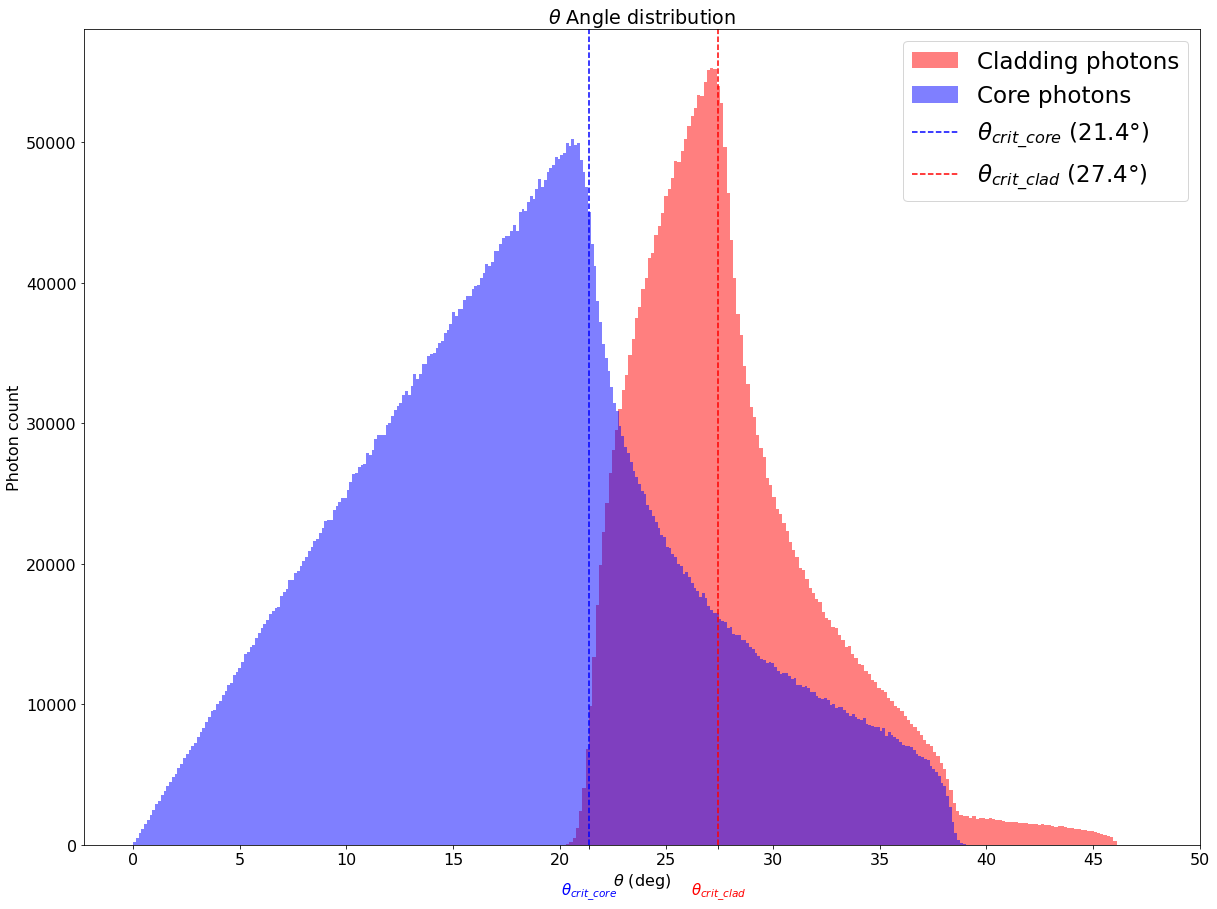

In [72]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,15))
plt.hist(clad_photons['Theta_deg'],bins=300,color='red',alpha=0.5,label='Cladding photons')
plt.hist(core_photons['Theta_deg'],bins=300,color='blue',alpha=0.5,label='Core photons')

theta_crit_core = 21.37
theta_crit_clad = 27.44
xticks = np.arange(0,51,5)
special_ticks = [theta_crit_core,theta_crit_clad]
xticks = np.sort(np.concatenate((xticks, special_ticks)))

plt.xticks(xticks, labels=[f'{tick:.0f}' if tick not in special_ticks 
                           else '' for tick in xticks])  

special_labels = ['$\\theta_{crit\_core}$',
                   '$\\theta_{crit\_clad}$']
colors = ['b', 'r']

for tick, label, color in zip(special_ticks, special_labels, colors):
    plt.axvline(x=tick, color=color, linestyle='--', label=f'{label} ({tick:.1f}°)')
    plt.text(tick, plt.ylim()[0] - (plt.ylim()[1] * 0.07), label,
              color=color, ha='center',va='bottom',
              fontsize=15)

plt.xlabel('$\\theta$ (deg)')
plt.ylabel('Photon count')
plt.title('{} Angle distribution'.format('$\\theta$'))

plt.legend(fontsize='x-large')

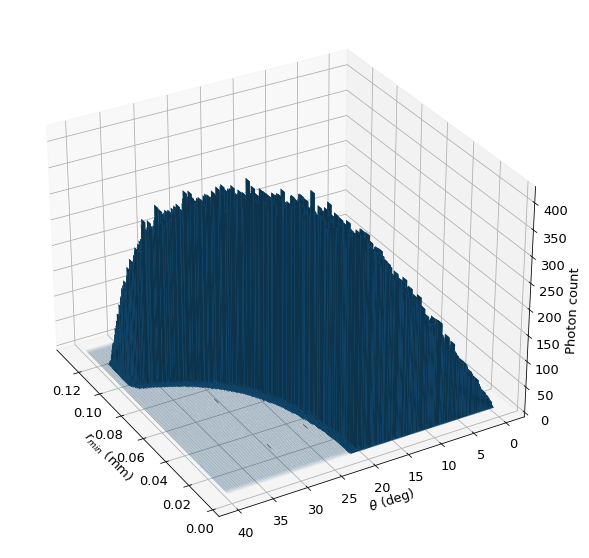

In [63]:
plt.rcParams.update({'font.size': 13})
# Creiamo la figura e gli assi 3D
fig = plt.figure(figsize=(17.5,10))
ax = fig.add_subplot(111, projection='3d')

# Selezioniamo i dati da merged_df
y = core_photons['Theta_deg']
x = core_photons['r_min']

# Creiamo l'istogramma tridimensionale
hist, xedges, yedges = np.histogram2d(x, y, bins=(250, 250),range=[[0,0.125], [0, 40]])

# Costruiamo i bar chart in 3D
xpos, ypos = np.meshgrid(xedges[:-1] + 0.004, yedges[:-1] + 0.004, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Dimensioni delle barre
dx = dy = 0.0035 * np.ones_like(zpos)
dz = hist.ravel()

# Creiamo il plot 3D
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

# Etichette degli assi
ax.set_ylabel('$\\theta$ (deg)')
ax.set_xlabel('$r_{min}$ (mm)')
ax.set_zlabel('Photon count')

ax.view_init(azim=150, elev=30)

plt.show()

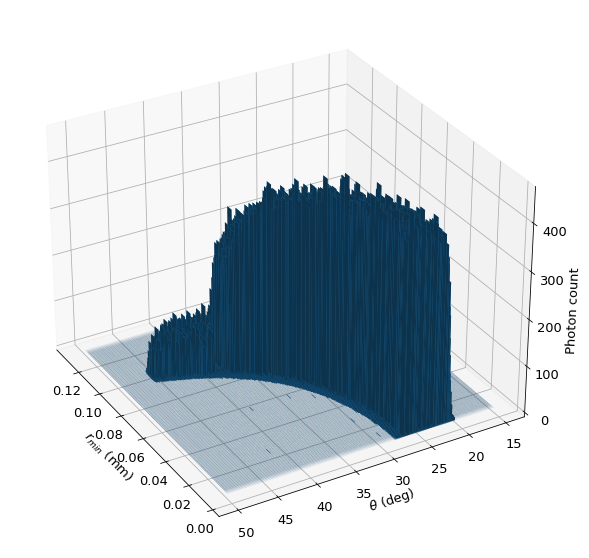

In [64]:
plt.rcParams.update({'font.size': 13})
# Creiamo la figura e gli assi 3D
fig = plt.figure(figsize=(17.5,10))
ax = fig.add_subplot(111, projection='3d')

# Selezioniamo i dati da merged_df
y = clad_photons['Theta_deg']
x = clad_photons['r_min']

# Creiamo l'istogramma tridimensionale
hist, xedges, yedges = np.histogram2d(x, y, bins=(250, 250),range=[[0,0.125], [15, 50]])

# Costruiamo i bar chart in 3D
xpos, ypos = np.meshgrid(xedges[:-1] + 0.004, yedges[:-1] + 0.004, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Dimensioni delle barre
dx = dy = 0.0035 * np.ones_like(zpos)
dz = hist.ravel()

# Creiamo il plot 3D
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

# Etichette degli assi
ax.set_ylabel('$\\theta$ (deg)')
ax.set_xlabel('$r_{min}$ (mm)')
ax.set_zlabel('Photon count')

ax.view_init(azim=150, elev=30)

plt.show()

Text(0.5, 0, '$r_{min}$ (mm)')

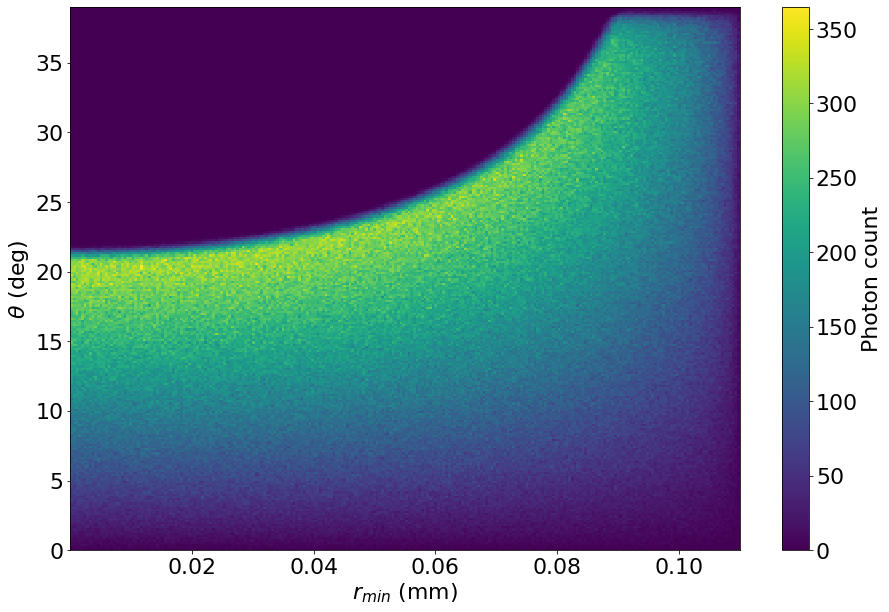

In [65]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(15,10))
_, _, _, img = plt.hist2d(core_photons['r_min'],core_photons['Theta_deg'],bins=[250,250])
fig.colorbar(img,label='Photon count')
plt.ylabel('$\\theta$ (deg)')
plt.xlabel('$r_{min}$ (mm)')

Text(0.5, 0, '$r_{min}$ (mm)')

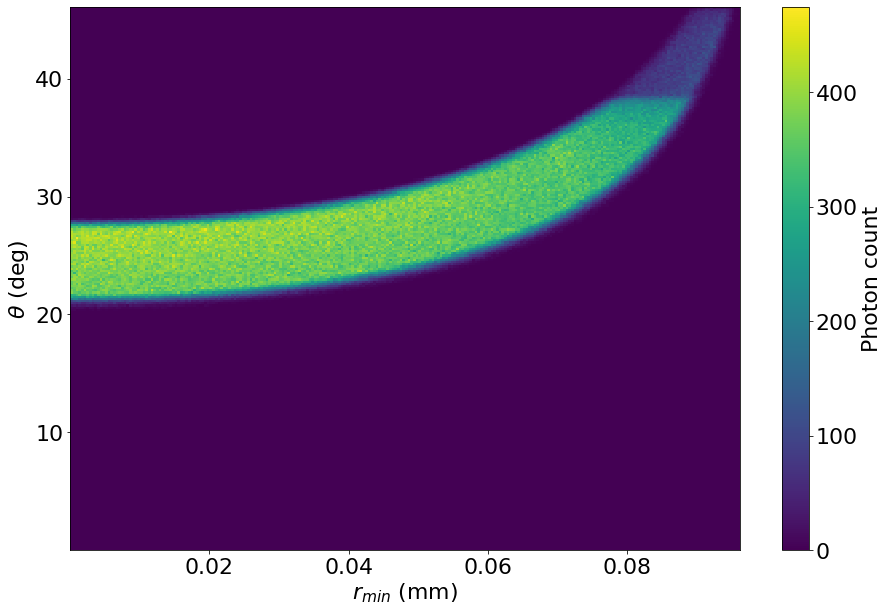

In [66]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(15,10))
_, _, _, img = plt.hist2d(clad_photons['r_min'],clad_photons['Theta_deg'],bins=[250,250])
fig.colorbar(img,label='Photon count')
plt.ylabel('$\\theta$ (deg)')
plt.xlabel('$r_{min}$ (mm)')

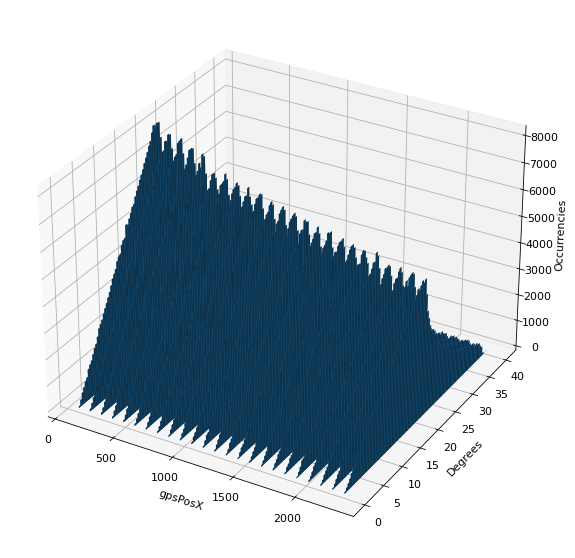

In [31]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(17.5,10))
ax = fig.add_subplot(projection='3d')
x, y = core_photons['gpsPosX'],core_photons['Theta_deg']
hist, xedges, yedges = np.histogram2d(x, y, bins=[24,100], range=[[100, 2400], [0, 40]])

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.04166, yedges[:-1] + 0.01, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.set_ylabel('Degrees')
ax.set_xlabel('gpsPosX')
ax.set_zlabel('Occurrencies')

plt.show()

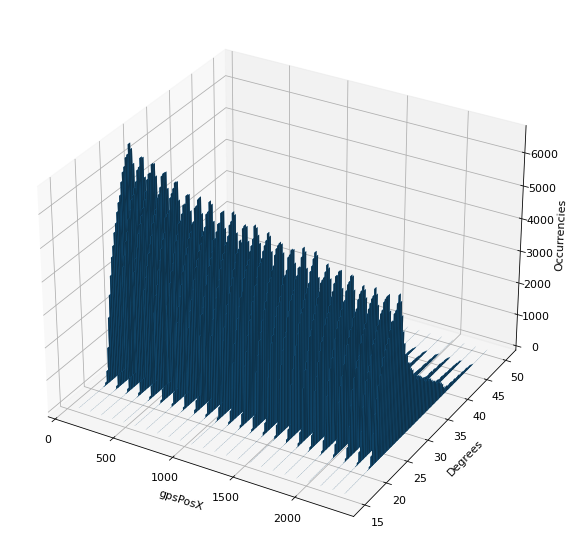

In [32]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(17.5,10))
ax = fig.add_subplot(projection='3d')
x, y = clad_photons['gpsPosX'],clad_photons['Theta_deg']
hist, xedges, yedges = np.histogram2d(x, y, bins=[24,100], range=[[100, 2400], [15, 50]])

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.04166, yedges[:-1] + 0.01, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.set_ylabel('Degrees')
ax.set_xlabel('gpsPosX')
ax.set_zlabel('Occurrencies')

plt.show()

Parametri adattati: a = 25652.156994301644, b = -0.1387941278629299
Parametri adattati: a = 19682.919030671543, b = -0.13930229296382518
Parametri adattati: a = 16182.060534079144, b = -0.14046825965891685


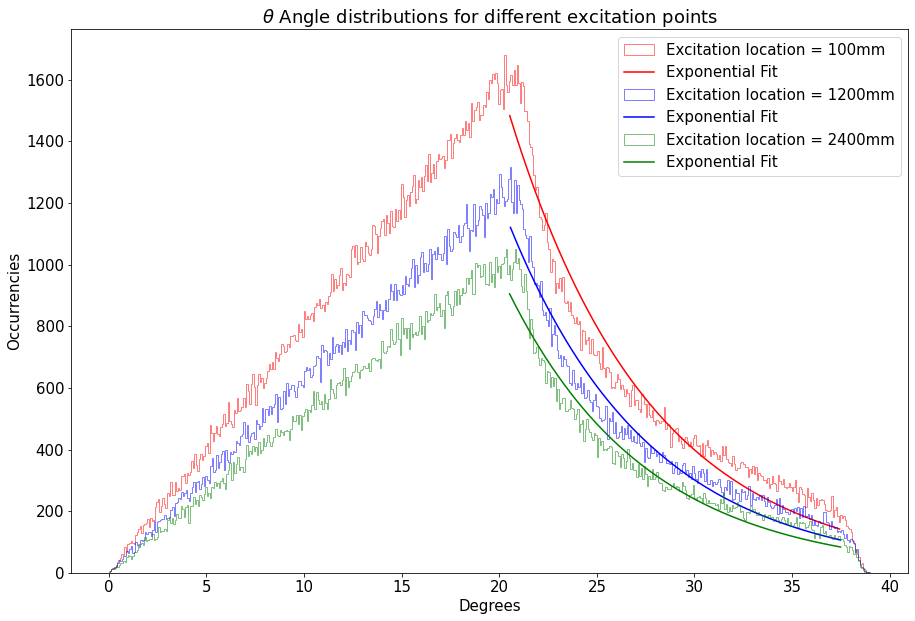

In [113]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})

def exponential(x, a, b):
    return a * np.exp(b * x)
range_min, range_max = 20.5, 37.5

core_photons_100mm = core_photons[core_photons['gpsPosX']==100]
core_photons_1000mm = core_photons[core_photons['gpsPosX']==1200]
core_photons_2400mm = core_photons[core_photons['gpsPosX']==2400]

counts, bins, _ = plt.hist(core_photons_100mm['Theta_deg'],bins=500,color='red',alpha=0.5,
         label='Excitation location = 100mm',histtype='step')

bin_centers = 0.5 * (bins[1:] + bins[:-1])
mask = (bin_centers >= range_min) & (bin_centers <= range_max)
bin_centers_filtered = bin_centers[mask]
counts_filtered = counts[mask]
popt, pcov = curve_fit(exponential, bin_centers_filtered, counts_filtered)
plt.plot(bin_centers_filtered, exponential(bin_centers_filtered, *popt), color='red',
          label='Exponential Fit')
print(f'Parametri adattati: a = {popt[0]}, b = {popt[1]}')

counts, bins, _ = plt.hist(core_photons_1000mm['Theta_deg'],bins=500,color='blue',alpha=0.5,
         label='Excitation location = 1200mm',histtype='step')

bin_centers = 0.5 * (bins[1:] + bins[:-1])
mask = (bin_centers >= range_min) & (bin_centers <= range_max)
bin_centers_filtered = bin_centers[mask]
counts_filtered = counts[mask]
popt, pcov = curve_fit(exponential, bin_centers_filtered, counts_filtered)
plt.plot(bin_centers_filtered, exponential(bin_centers_filtered, *popt), color='blue',
          label='Exponential Fit')
print(f'Parametri adattati: a = {popt[0]}, b = {popt[1]}')

counts, bins, _ = plt.hist(core_photons_2400mm['Theta_deg'],bins=500,color='green',alpha=0.5,
         label='Excitation location = 2400mm',histtype='step')

bin_centers = 0.5 * (bins[1:] + bins[:-1])
mask = (bin_centers >= range_min) & (bin_centers <= range_max)
bin_centers_filtered = bin_centers[mask]
counts_filtered = counts[mask]
popt, pcov = curve_fit(exponential, bin_centers_filtered, counts_filtered)
plt.plot(bin_centers_filtered, exponential(bin_centers_filtered, *popt), color='green',
          label='Exponential Fit')
print(f'Parametri adattati: a = {popt[0]}, b = {popt[1]}')

plt.xlabel('Degrees')
plt.ylabel('Occurrencies')
plt.title('{} Angle distributions for different excitation points'.format('$\\theta$'))

plt.legend(fontsize='medium')

For $\theta$ = 26°: a = 5014.344286524515, b = -0.18915928722012382
For $\theta$ = 20°: a = 3986.05628065838, b = -0.19894548370051351
For $\theta$ = 37°: a = 1078.6095620386818, b = -0.23043677173642546


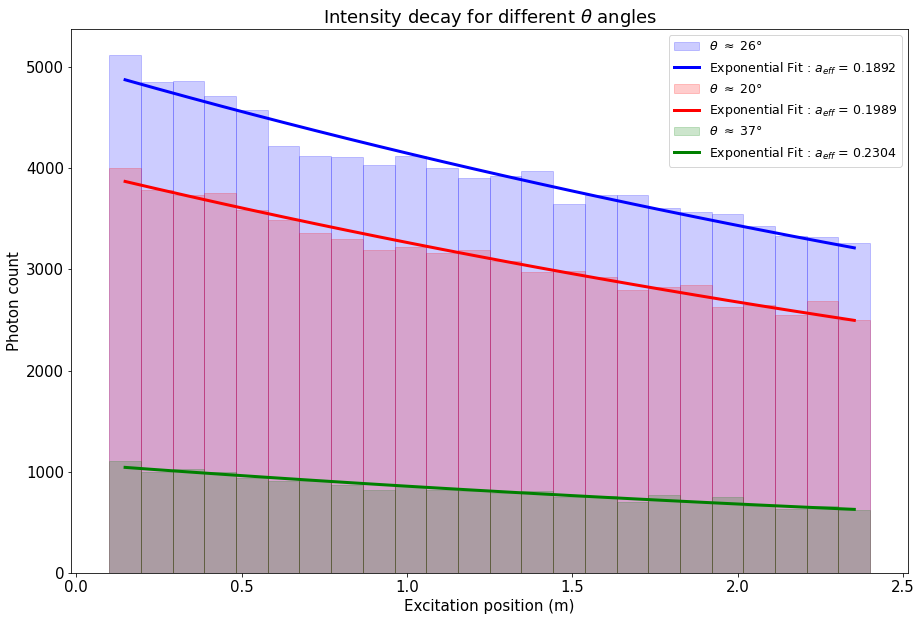

In [104]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
def exponential(x, a, b):
    return a * np.exp(b*x)


merged_df_20deg = merged_df[(merged_df['Theta_deg']<=20.1) &
                                  (merged_df['Theta_deg']>=19.9)]
merged_df_21deg = merged_df[(merged_df['Theta_deg']<=21.1) &
                                  (merged_df['Theta_deg']>=20.9)]
merged_df_26deg = merged_df[(merged_df['Theta_deg']<=26.1) &
                                  (merged_df['Theta_deg']>=25.9)]
merged_df_37deg = merged_df[(merged_df['Theta_deg']<=37.1) &
                                  (merged_df['Theta_deg']>=36.9)]


counts, bins, _ = plt.hist(merged_df_26deg['gpsPosX']/1000,bins=24,color='blue',alpha=0.2,
         label='$\\theta$ $\\approx$ 26°',edgecolor='blue')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(exponential, bin_centers, counts)
plt.plot(bin_centers, exponential(bin_centers, *popt), color='blue',
          label='Exponential Fit : {} = {}'
          .format('$a_{eff}$',f"{-popt[1]:.4g}"),linewidth=3)
print(f'For $\\theta$ = 26°: a = {popt[0]}, b = {popt[1]}')


counts, bins, _ = plt.hist(merged_df_20deg['gpsPosX']/1000,bins=24,color='red',alpha=0.2,
         label='$\\theta$ $\\approx$ 20°',edgecolor='red')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(exponential, bin_centers, counts)
plt.plot(bin_centers, exponential(bin_centers, *popt), color='red',
          label='Exponential Fit : {} = {}'.format('$a_{eff}$',f"{-popt[1]:.4g}"),linewidth=3)
print(f'For $\\theta$ = 20°: a = {popt[0]}, b = {popt[1]}')


counts, bins, _ = plt.hist(merged_df_37deg['gpsPosX']/1000,bins=24,color='green',alpha=0.2,
         label='$\\theta$ $\\approx$ 37°',edgecolor='green')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(exponential, bin_centers, counts)
plt.plot(bin_centers, exponential(bin_centers, *popt), color='green',
          label='Exponential Fit : {} = {}'.format('$a_{eff}$',f"{-popt[1]:.4g}"),linewidth=3)
print(f'For $\\theta$ = 37°: a = {popt[0]}, b = {popt[1]}')


plt.xlabel('Excitation position (m)')
plt.ylabel('Photon count')
plt.title('Intensity decay for different {} angles'.format('$\\theta$'))

plt.legend(fontsize='small')

$\theta_{pred}(20°)$ = 0.1946

$\theta_{pred}(26°)$ = 0.2178

$\theta_{pred}(37°)$ = 0.2715

Parametri adattati: a = 345284.60023095924, b = -0.21789645822081977
Parametri adattati: a = 278645.98681221413, b = -0.2181928799630511
Parametri adattati: a = 242246.67241212865, b = -0.22123243707087034


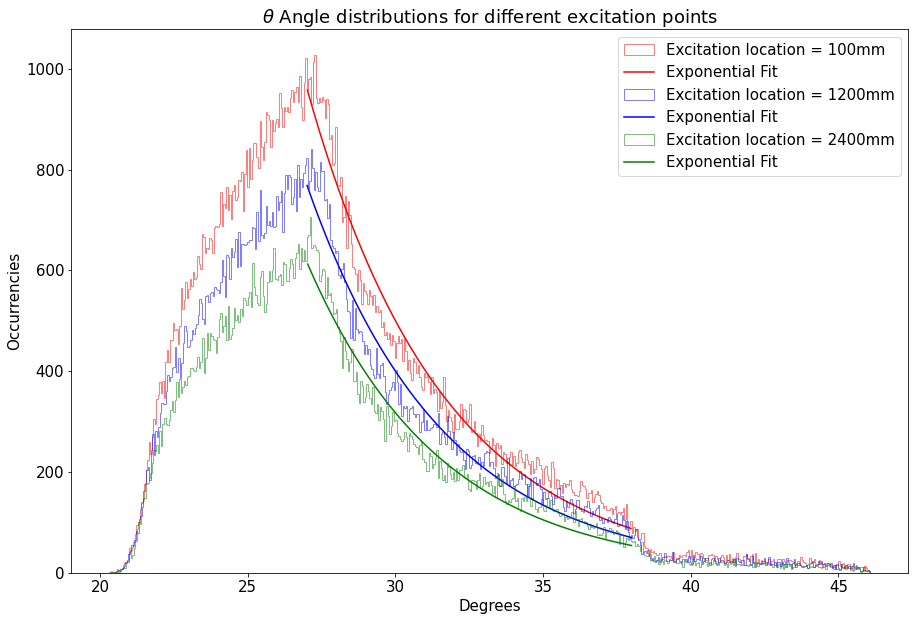

In [10]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})

def exponential(x, a, b):
    return a * np.exp(b * x)
range_min, range_max = 27, 38

clad_photons_100mm = clad_photons[clad_photons['gpsPosX']==100]
clad_photons_1000mm = clad_photons[clad_photons['gpsPosX']==1200]
clad_photons_2400mm = clad_photons[clad_photons['gpsPosX']==2400]

counts, bins, _ = plt.hist(clad_photons_100mm['Theta_deg'],bins=500,color='red',alpha=0.5,
         label='Excitation location = 100mm',histtype='step')

bin_centers = 0.5 * (bins[1:] + bins[:-1])
mask = (bin_centers >= range_min) & (bin_centers <= range_max)
bin_centers_filtered = bin_centers[mask]
counts_filtered = counts[mask]
popt, pcov = curve_fit(exponential, bin_centers_filtered, counts_filtered)
plt.plot(bin_centers_filtered, exponential(bin_centers_filtered, *popt), color='red',
          label='Exponential Fit')
print(f'Parametri adattati: a = {popt[0]}, b = {popt[1]}')

counts, bins, _ = plt.hist(clad_photons_1200mm['Theta_deg'],bins=500,color='blue',alpha=0.5,
         label='Excitation location = 1200mm',histtype='step')

bin_centers = 0.5 * (bins[1:] + bins[:-1])
mask = (bin_centers >= range_min) & (bin_centers <= range_max)
bin_centers_filtered = bin_centers[mask]
counts_filtered = counts[mask]
popt, pcov = curve_fit(exponential, bin_centers_filtered, counts_filtered)
plt.plot(bin_centers_filtered, exponential(bin_centers_filtered, *popt), color='blue',
          label='Exponential Fit')
print(f'Parametri adattati: a = {popt[0]}, b = {popt[1]}')

counts, bins, _ = plt.hist(clad_photons_2400mm['Theta_deg'],bins=500,color='green',alpha=0.5,
         label='Excitation location = 2400mm',histtype='step')

bin_centers = 0.5 * (bins[1:] + bins[:-1])
mask = (bin_centers >= range_min) & (bin_centers <= range_max)
bin_centers_filtered = bin_centers[mask]
counts_filtered = counts[mask]
popt, pcov = curve_fit(exponential, bin_centers_filtered, counts_filtered)
plt.plot(bin_centers_filtered, exponential(bin_centers_filtered, *popt), color='green',
          label='Exponential Fit')
print(f'Parametri adattati: a = {popt[0]}, b = {popt[1]}')

plt.xlabel('Degrees')
plt.ylabel('Occurrencies')
plt.title('{} Angle distributions for different excitation points'.format('$\\theta$'))

plt.legend(fontsize='medium')

For $\theta$ = 26°: a = 5014.344286524515, b = -0.18915928722012382
For $\theta$ = 23°: a = 4606.483659614639, b = -0.20272188013143122
For $\theta$ = 20°: a = 3986.05628065838, b = -0.19894548370051351


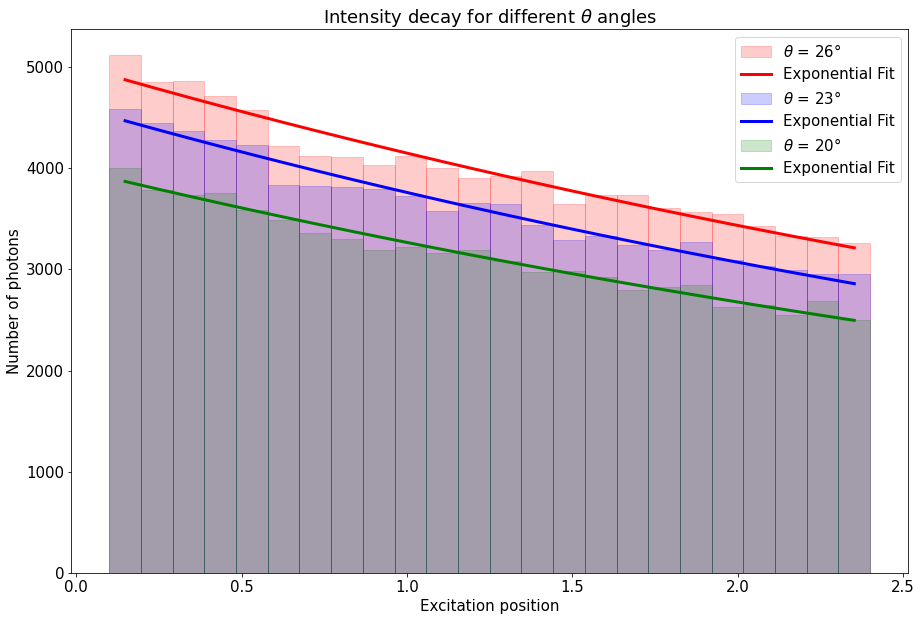

In [22]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
def exponential(x, a, b):
    return a * np.exp(b*x)


all_photons_20deg = merged_df[(merged_df['Theta_deg']<=20.1) &
                                  (merged_df['Theta_deg']>=19.9)]
all_photons_23deg = merged_df[(merged_df['Theta_deg']<=23.1) &
                                  (merged_df['Theta_deg']>=22.9)]
all_photons_26deg = merged_df[(merged_df['Theta_deg']<=26.1) &
                                  (merged_df['Theta_deg']>=25.9)]


counts, bins, _ = plt.hist(all_photons_26deg['gpsPosX']/1000,bins=24,color='red',alpha=0.2,
         label='$\\theta$ = 26°',edgecolor='red')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(exponential, bin_centers, counts)
plt.plot(bin_centers, exponential(bin_centers, *popt), color='red',
          label='Exponential Fit',linewidth=3)
print(f'For $\\theta$ = 26°: a = {popt[0]}, b = {popt[1]}')


counts, bins, _ = plt.hist(all_photons_23deg['gpsPosX']/1000,bins=24,color='blue',alpha=0.2,
         label='$\\theta$ = 23°',edgecolor='blue')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(exponential, bin_centers, counts)
plt.plot(bin_centers, exponential(bin_centers, *popt), color='blue',
          label='Exponential Fit',linewidth=3)
print(f'For $\\theta$ = 23°: a = {popt[0]}, b = {popt[1]}')


counts, bins, _ = plt.hist(all_photons_20deg['gpsPosX']/1000,bins=24,color='green',alpha=0.2,
         label='$\\theta$ = 20°',edgecolor='green')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(exponential, bin_centers, counts)
plt.plot(bin_centers, exponential(bin_centers, *popt), color='green',
          label='Exponential Fit',linewidth=3)
print(f'For $\\theta$ = 20°: a = {popt[0]}, b = {popt[1]}')


plt.xlabel('Excitation position')
plt.ylabel('Number of photons')
plt.title('Intensity decay for different {} angles'.format('$\\theta$'))

plt.legend(fontsize='medium')

[0.21214834448683173, 0.21001077134735213, 0.19680749134678316, 0.19445106804699094, 0.2010610810245225, 0.19626541714768536, 0.19950648323697187, 0.19105557979337687, 0.2105244387298785, 0.19566088605431434, 0.18384051985581926, 0.19573350732955747, 0.1936010807585691, 0.19639248500128, 0.2052318510099897, 0.1956530454166519, 0.19688874793890873, 0.2020786804296285, 0.1850568816912827, 0.19894548370051351, 0.2060104302392848, 0.18542528553237209, 0.20272188013143122, 0.1805427787483849, 0.20118560647534361, 0.18915928722012382, 0.19434165585373134, 0.22174586870203233, 0.19977574733918002, 0.20640225562306524, 0.20968502886509963, 0.2051609835096998, 0.20648621486326332, 0.21076224495712673, 0.2125166452671925]
[0.018690414949098694, 0.0154122957393887, 0.014496476993634879, 0.014793098148893232, 0.013098358640774167, 0.010030508519447605, 0.009855766796794115, 0.01031041314318685, 0.009154266369765006, 0.008045331700791792, 0.010734819015099468, 0.008615930172982855, 0.00731574730925

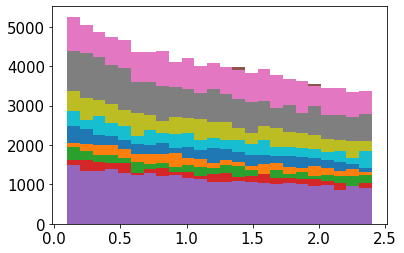

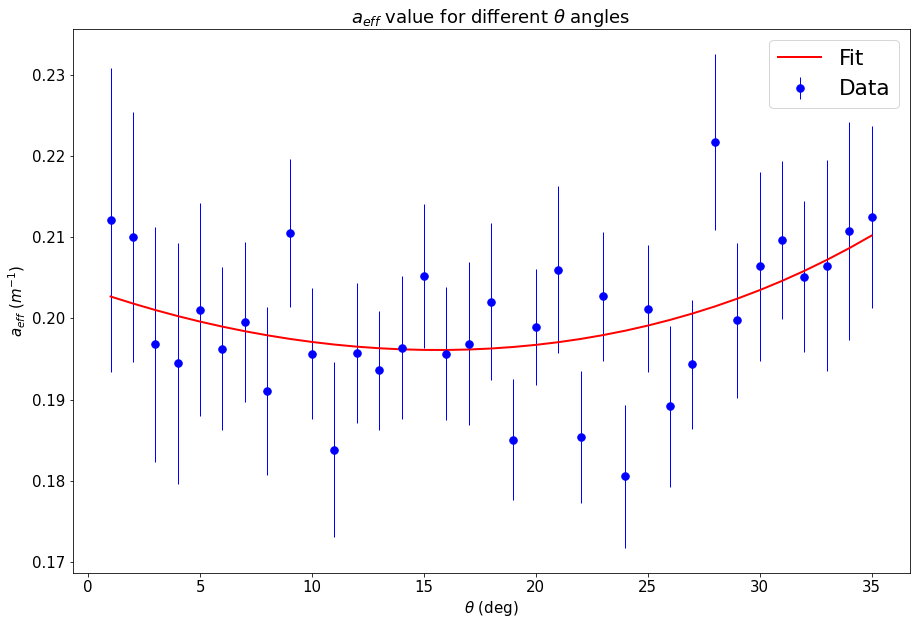

In [108]:
def exponential(x, a, b):
    return a * np.exp(b*x)

coeffs = []
errs = []
exp_c1 = []
exp_c2 = []
r_min_av = np.average(merged_df['r_min'])
r_min_av_err = np.std(merged_df['r_min'])

theta_span = np.arange(1,36)

for n in theta_span :
    photons = merged_df[(merged_df['Theta_deg']<=n+0.1) &
                                  (merged_df['Theta_deg']>=n-0.1)]
    counts, bins, _ = plt.hist(photons['gpsPosX']/1000,bins=24)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    popt, pcov = curve_fit(exponential, bin_centers, counts)
    coeffs.append(-popt[1])
    errs.append(np.sqrt(pcov[1,1]))

def coeff_func(x, a, b):
    return a/np.cos(np.deg2rad(x)) + b*np.tan(np.deg2rad(x))

print(coeffs)
print(errs)

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
popt, pcov = curve_fit(coeff_func, theta_span, coeffs)
#plt.scatter(theta_span,coeffs,marker='x',c='blue',label='Data')
plt.errorbar(theta_span,coeffs,errs,c='blue',marker='.',
             markersize=15,linestyle='--',elinewidth=1,linewidth=0,label='Data')
plt.plot(theta_span, coeff_func(theta_span, *popt), color='red',linewidth=2,
          label='Fit')
          #: {} = {}\n{} = {}'  .format('$c_{1}$',f"{-popt[0]:.4g}",'$c_{2}$',f"{-popt[1]:.4g}"))
print(popt)
print(r_min_av,'+-',r_min_av_err)
print(0.00001/(2*np.sqrt(0.00011**2-(r_min_av*0.001)**2)))


plt.xlabel('$\\theta$ (deg)')
plt.ylabel('$a_{eff}$ $(m^{-1})$')
plt.title('{} value for different {} angles'.format('$a_{eff}$','$\\theta$'))
plt.legend(fontsize='x-large')